# Marketing Campaign Results

source: https://platform.stratascratch.com/data-projects/marketing-campaign-results

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

### Readin data and initial processsing

In [3]:
client = pd.read_csv("./datasets/client_data.csv")
deposit = pd.read_csv("./datasets/deposit_data.csv")
calendar = pd.read_csv("./datasets/calendar_data.csv")

In [4]:
print(client.info())
print(deposit.info())
print(calendar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46347 entries, 0 to 46346
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   client_id                   46347 non-null  int64 
 1   client_geographical_region  46347 non-null  object
 2   client_residence_status     46347 non-null  object
 3   client_age                  46347 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480394 entries, 0 to 480393
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   client_id        480394 non-null  int64  
 1   deposit_type     480394 non-null  object 
 2   deposit_amount   480394 non-null  float64
 3   deposit_cadence  480394 non-null  object 
 4   deposit_date     480394 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 18.3+ MB

#### Combine three data sets into one master dataset

In [5]:
master = deposit.merge(client, on="client_id", how="left").merge(
    calendar, left_on="deposit_date", right_on="gregorian_date", how="left"
)

#### Data exploration

##### Numerical variables overview

In [6]:
master.describe()

,client_id,deposit_amount,client_age
count,4.803940e+05,480394.000000,480394.000000
mean,4.992809e+14,365.207130,52.192469
std,2.899833e+14,346.644434,13.773928
min,1.460463e+11,0.010000,21.000000
25%,2.477689e+14,200.000000,41.000000
50%,5.015297e+14,290.000000,52.000000
75%,7.503108e+14,452.000000,62.000000
max,9.999856e+14,30000.000000,105.000000


##### Categorical variables overview

In [7]:
catVars = master.select_dtypes("object").columns.to_list()

for v in catVars:
    print(f"{v}: {master[v].nunique()} {master[v].unique()[0:10]}")

deposit_type: 2 ['Actual Deposit' 'Scheduled Deposit']
deposit_cadence: 3 ['Monthly' 'Biweekly' 'Extra']
deposit_date: 153 ['2019-10-23' '2019-09-23' '2019-06-23' '2019-07-23' '2019-08-23'
 '2019-09-12' '2019-09-26' '2019-06-22' '2019-07-06' '2019-06-08']
client_geographical_region: 4 ['West' 'South' 'Northeast' 'Midwest']
client_residence_status: 2 ['Rent' 'Own']
gregorian_date: 153 ['2019-10-23' '2019-09-23' '2019-06-23' '2019-07-23' '2019-08-23'
 '2019-09-12' '2019-09-26' '2019-06-22' '2019-07-06' '2019-06-08']
month_name: 5 ['Month 5' 'Month 4' 'Month 1' 'Month 2' 'Month 3']


##### Check missings

In [8]:
master.isna().sum()

client_id                     0
deposit_type                  0
deposit_amount                0
deposit_cadence               0
deposit_date                  0
client_geographical_region    0
client_residence_status       0
client_age                    0
gregorian_date                0
month_name                    0
dtype: int64

##### Can a client's desposit cadence change? - yes

In [9]:
x = (
    deposit.sort_values(["client_id", "deposit_cadence"])
    .groupby("client_id", as_index=False)
    .deposit_cadence.unique()
    .assign(deposit_cadence=lambda x: x.deposit_cadence.apply(tuple))
)
x.deposit_cadence.value_counts()

deposit_cadence
(Monthly,)                    29271
(Biweekly,)                   11766
(Extra, Monthly)               3048
(Biweekly, Extra)              1142
(Extra,)                        845
(Biweekly, Monthly)             212
(Biweekly, Extra, Monthly)       63
Name: count, dtype: int64

An example of client switching cadence and also making extra payment

In [10]:
master.query("client_id == 945195860266").sort_values(["deposit_date", "deposit_type"])

,client_id,deposit_type,deposit_amount,deposit_cadence,deposit_date,client_geographical_region,client_residence_status,client_age,gregorian_date,month_name
60653,945195860266,Actual Deposit,348.0,Monthly,2019-06-16,West,Rent,34,2019-06-16,Month 1
60651,945195860266,Scheduled Deposit,348.0,Monthly,2019-06-16,West,Rent,34,2019-06-16,Month 1
166676,945195860266,Actual Deposit,174.0,Monthly,2019-07-20,West,Rent,34,2019-07-20,Month 2
166675,945195860266,Scheduled Deposit,174.0,Monthly,2019-07-20,West,Rent,34,2019-07-20,Month 2
60652,945195860266,Actual Deposit,174.0,Extra,2019-07-27,West,Rent,34,2019-07-27,Month 2
207569,945195860266,Actual Deposit,174.0,Biweekly,2019-08-10,West,Rent,34,2019-08-10,Month 3
207568,945195860266,Scheduled Deposit,174.0,Biweekly,2019-08-10,West,Rent,34,2019-08-10,Month 3
60655,945195860266,Actual Deposit,174.0,Biweekly,2019-08-24,West,Rent,34,2019-08-24,Month 3
60654,945195860266,Scheduled Deposit,174.0,Biweekly,2019-08-24,West,Rent,34,2019-08-24,Month 3
60646,945195860266,Actual Deposit,174.0,Biweekly,2019-09-07,West,Rent,34,2019-09-07,Month 4


##### Can the Scheduled deposit and actual deposit be different? - yes

In [11]:
(
    master.query("deposit_type.isin(['Actual Deposit', 'Scheduled Deposit'])")
    .pivot_table(
        index=["client_id", "deposit_date"],
        columns="deposit_type",
        values="deposit_amount",
    )
    .dropna()
    .rename(
        {"Actual Deposit": "Actual_Deposit", "Scheduled Deposit": "Scheduled_Deposit"},
        axis=1,
    )
    .query("Actual_Deposit != Scheduled_Deposit")
)

deposit_type                  Actual_Deposit  Scheduled_Deposit
client_id       deposit_date                                   
625882515630    2019-10-20              97.0             133.00
1211140273733   2019-08-09             322.0             261.00
                2019-08-23             322.0             261.00
1274168007988   2019-10-06             223.0             246.00
2035251420486   2019-10-10             560.0             620.00
...                                      ...                ...
993234555530702 2019-10-22              25.0             190.50
997135926563943 2019-08-12             375.0             418.75
                2019-08-26             375.0             418.75
997567464814353 2019-06-26             100.0            1026.00
999904264600900 2019-08-02             418.0             835.00

[854 rows x 2 columns]

Are there clients who dropped out before month 3, or joined after month 3? - Yes
We do not know the reasons for drop out or join
Assuming the ad campaign is marketed to the general market, we would consider all clients for the deposit increase or decrease, regardless when they joined the program

In [12]:
master.groupby("client_id", as_index=False).month_name.nunique().query("month_name < 5")

,client_id,month_name
1,157359753147,1
3,208393955689,3
7,272046076552,1
12,350389766713,3
15,381934926331,3
...,...,...
46329,999622154605650,3
46332,999628703060909,2
46333,999635764294384,3
46339,999711207948964,3


In [13]:
master.query("client_id == 157359753147")

,client_id,deposit_type,deposit_amount,deposit_cadence,deposit_date,client_geographical_region,client_residence_status,client_age,gregorian_date,month_name
80997,157359753147,Scheduled Deposit,705.0,Monthly,2019-06-04,West,Own,85,2019-06-04,Month 1
80998,157359753147,Actual Deposit,705.0,Monthly,2019-06-04,West,Own,85,2019-06-04,Month 1


Not all actual deposit has a corresponding scheduled deposit. It may be because it is an extra payment, or no reason at all.
Not all scheduled deposit would result in an actual deposit. 
Therefore we shall just focus on actual deposit because that is what happened in real.

In [14]:
# Missing scheduled deposit
master.query("client_id == 714514923232")

,client_id,deposit_type,deposit_amount,deposit_cadence,deposit_date,client_geographical_region,client_residence_status,client_age,gregorian_date,month_name
16753,714514923232,Scheduled Deposit,398.0,Monthly,2019-06-25,West,Own,70,2019-06-25,Month 1
16754,714514923232,Actual Deposit,398.0,Monthly,2019-06-25,West,Own,70,2019-06-25,Month 1
168816,714514923232,Scheduled Deposit,398.0,Monthly,2019-07-25,West,Own,70,2019-07-25,Month 2
168817,714514923232,Actual Deposit,398.0,Monthly,2019-07-25,West,Own,70,2019-07-25,Month 2
245570,714514923232,Actual Deposit,398.0,Monthly,2019-08-25,West,Own,70,2019-08-25,Month 3
310149,714514923232,Actual Deposit,398.0,Monthly,2019-10-25,West,Own,70,2019-10-25,Month 5
439347,714514923232,Actual Deposit,398.0,Monthly,2019-09-25,West,Own,70,2019-09-25,Month 4


In [15]:
# Missing actual deposit
master.query("client_id == 253175837503").sort_values(["month_name", "deposit_type"])

,client_id,deposit_type,deposit_amount,deposit_cadence,deposit_date,client_geographical_region,client_residence_status,client_age,gregorian_date,month_name
38830,253175837503,Scheduled Deposit,246.0,Monthly,2019-06-13,Northeast,Own,69,2019-06-13,Month 1
38831,253175837503,Scheduled Deposit,246.0,Monthly,2019-07-13,Northeast,Own,69,2019-07-13,Month 2
211502,253175837503,Scheduled Deposit,246.0,Monthly,2019-08-13,Northeast,Own,69,2019-08-13,Month 3
404004,253175837503,Scheduled Deposit,246.0,Monthly,2019-09-13,Northeast,Own,69,2019-09-13,Month 4
276126,253175837503,Scheduled Deposit,246.0,Monthly,2019-10-13,Northeast,Own,69,2019-10-13,Month 5


##### Create a client level data set pre-and post-compaign change

In [16]:
master.columns

Index(['client_id', 'deposit_type', 'deposit_amount', 'deposit_cadence',
       'deposit_date', 'client_geographical_region', 'client_residence_status',
       'client_age', 'gregorian_date', 'month_name'],
      dtype='object')

In [17]:
master.deposit_cadence.value_counts()

deposit_cadence
Monthly     262858
Biweekly    209189
Extra         8347
Name: count, dtype: int64

In [18]:
campaign = (
    master.query('deposit_type == "Actual Deposit"')
    .assign(extra_payment=lambda x: np.where(x.deposit_type == "Extra", 1, 0))
    .groupby(
        [
            "client_id",
            "client_geographical_region",
            "client_residence_status",
            "client_age",
            "month_name",
        ]
    )
    .agg(
        deposit_amount=("deposit_amount", "sum"),
        extra_payment=("extra_payment", "sum"),
        dominant_cadence=("deposit_cadence", lambda x: x.mode()[0]),
    )
    .reset_index()
    .assign(
        month=lambda x: x.month_name.str[-1].astype(int),
        stage=lambda x: x.month.case_when(
            [
                (x.month.isin([1, 2]), "1. Pre-campaign"),
                (x.month.isin([4, 5]), "3. Post-campaign"),
                (x.month.isin([3]), "2. In-compaign"),
            ]
        ),
    )
)
campaign

,client_id,client_geographical_region,client_residence_status,client_age,month_name,deposit_amount,extra_payment,dominant_cadence,month,stage
0,146046305811,Midwest,Rent,42,Month 1,494.0,0,Biweekly,1,1. Pre-campaign
1,146046305811,Midwest,Rent,42,Month 2,741.0,0,Biweekly,2,1. Pre-campaign
2,146046305811,Midwest,Rent,42,Month 3,494.0,0,Biweekly,3,2. In-compaign
3,146046305811,Midwest,Rent,42,Month 4,494.0,0,Biweekly,4,3. Post-campaign
4,146046305811,Midwest,Rent,42,Month 5,494.0,0,Biweekly,5,3. Post-campaign
...,...,...,...,...,...,...,...,...,...,...
173581,999985563097570,West,Own,54,Month 1,300.0,0,Biweekly,1,1. Pre-campaign
173582,999985563097570,West,Own,54,Month 2,300.0,0,Biweekly,2,1. Pre-campaign
173583,999985563097570,West,Own,54,Month 3,300.0,0,Biweekly,3,2. In-compaign
173584,999985563097570,West,Own,54,Month 4,300.0,0,Biweekly,4,3. Post-campaign


<Axes: xlabel='month', ylabel='deposit_amount'>

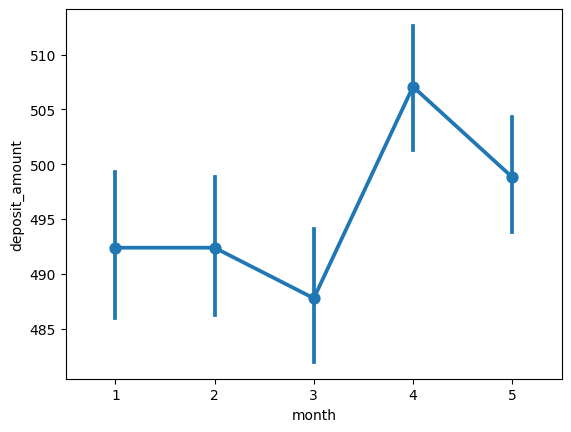

In [19]:
sns.pointplot(campaign, x="month", y="deposit_amount")

### (1) Marketing effects

No difference in the deposit cadence pre and post-campaign

In [20]:
pd.crosstab(campaign.stage, campaign.dominant_cadence, normalize="index")

dominant_cadence,Biweekly,Extra,Monthly
stage,,,
1. Pre-campaign,0.282723,0.029635,0.687642
2. In-compaign,0.283259,0.039024,0.677718
3. Post-campaign,0.288070,0.033714,0.678217


In [21]:
summarydf = (
    campaign.groupby("stage")
    .agg(n_clients=("client_id", "nunique"), deposit=("deposit_amount", "sum"))
    .assign(deposit_per_user=lambda x: x.deposit / x.n_clients)
    .transpose()
    .reset_index()
    .rename({"index": "stage"}, axis=1)
)
summarydf

stage,stage,1. Pre-campaign,2. In-compaign,3. Post-campaign
0,n_clients,3.145400e+04,4.002700e+04,3.896300e+04
1,deposit,2.894381e+07,1.952439e+07,3.760925e+07
2,deposit_per_user,9.201948e+02,4.877806e+02,9.652554e+02


In [22]:
total_deposit_increase = (
    (
        summarydf[summarydf.stage == "deposit"]["3. Post-campaign"]
        - summarydf[summarydf.stage == "deposit"]["1. Pre-campaign"]
    )
    .iloc[0]
    .item()  # Convert np.float to native python float
)

deposit_increase_pct = (
    total_deposit_increase
    / summarydf[summarydf.stage == "deposit"]["1. Pre-campaign"].iloc[0].item()
    * 100
)

fee_pct = 0.05
duration = 12
increased_profit = total_deposit_increase * fee_pct * duration

print(f"""
      The total deposit increased by {total_deposit_increase:.2f}, which is a {deposit_increase_pct=:.2f}% increase from the pre-campaign deposit.
      Assuming a fee of {fee_pct*100}%, and the effects of campaign lasting for {duration} months, the total profit due to the campaign is {increased_profit}
      This is more than than cost ($5,000,000) of the campaign, suggesting the campaign is successfull
      --------------------------------------------------------
      {total_deposit_increase=}
      {deposit_increase_pct=:.2f}%
      {fee_pct=}
      {duration=}
      {increased_profit=}
      """)



      The total deposit increased by 8665440.15, which is a deposit_increase_pct=29.94% increase from the pre-campaign deposit.
      Assuming a fee of 5.0%, and the effects of campaign lasting for 12 months, the total profit due to the campaign is 5199264.09
      This is more than than cost ($5,000,000) of the campaign, suggesting the campaign is successfull
      --------------------------------------------------------
      total_deposit_increase=8665440.149999999
      deposit_increase_pct=29.94%
      fee_pct=0.05
      duration=12
      increased_profit=5199264.09
      


### (2) Campaign patterns

In [23]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173586 entries, 0 to 173585
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   client_id                   173586 non-null  int64  
 1   client_geographical_region  173586 non-null  object 
 2   client_residence_status     173586 non-null  object 
 3   client_age                  173586 non-null  int64  
 4   month_name                  173586 non-null  object 
 5   deposit_amount              173586 non-null  float64
 6   extra_payment               173586 non-null  int32  
 7   dominant_cadence            173586 non-null  object 
 8   month                       173586 non-null  int32  
 9   stage                       173586 non-null  object 
dtypes: float64(1), int32(2), int64(2), object(5)
memory usage: 11.9+ MB


In [40]:
campaign2 = (
    campaign[campaign.stage.isin(["1. Pre-campaign", "3. Post-campaign"])]
    .groupby(
        [
            "client_id",
            "client_geographical_region",
            "client_residence_status",
            "client_age",
            "extra_payment",
            "dominant_cadence",
            "stage",
        ],
        as_index=False,
    )
    .deposit_amount.sum()
    .assign(client_age_cat=lambda x: pd.cut(x.client_age, [20, 30, 40, 50, 65, 120]))
)

#### Visualization of the patterns
Clients in regions South or Northeast are more likely to increase deposit after the campaign
Clients who rent are more likely to increase deposit after the campaign
Clients below age 50 are more likely to increase deposit after the campaign

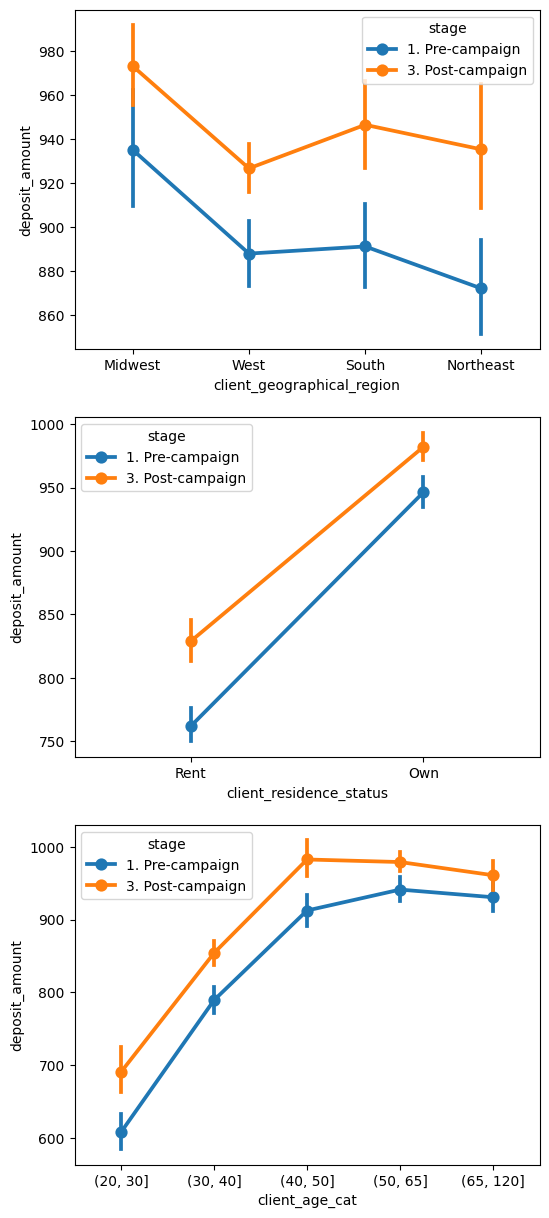

In [41]:
vars = ["client_geographical_region", "client_residence_status", "client_age_cat"]
fig, axes = plt.subplots(ncols=1, nrows=len(vars), figsize=(6, 15))
axes = axes.flatten()

for i, var in enumerate(vars):
    sns.pointplot(
        campaign2,
        x=var,
        y="deposit_amount",
        hue="stage",
        ax=axes[i],
    )

#### GLM validation
Validate the hypothsis with GLM

In [ ]:
campaign2.client_age_cat.value_counts(dropna=False)

client_age_cat
(50, 65]     25064
(40, 50]     16460
(65, 120]    15444
(30, 40]     12309
(20, 30]      3042
Name: count, dtype: int64

In [ ]:
client_overall = (
    campaign2.pivot(
        index=[
            "client_id",
            "client_geographical_region",
            "client_residence_status",
            "client_age_cat",
            "extra_payment",
            "dominant_cadence",
        ],
        columns="stage",
        values="deposit_amount",
    )
    .reset_index()
    .assign(
        deposit_increase=lambda x: x["3. Post-campaign"] - x["1. Pre-campaign"],
        client_age_cat=lambda x: x.client_age_cat.astype(str),
    )
    .fillna(0)
)
client_overall

stage,client_id,client_geographical_region,client_residence_status,client_age_cat,extra_payment,dominant_cadence,1. Pre-campaign,3. Post-campaign,deposit_increase
0,146046305811,Midwest,Rent,"(40, 50]",0,Biweekly,1235.0,988.0,-247.0
1,157359753147,West,Own,"(65, 120]",0,Monthly,705.0,0.0,0.0
2,191641185434,Midwest,Own,"(50, 65]",0,Monthly,988.0,988.0,0.0
3,208393955689,South,Own,"(50, 65]",0,Biweekly,0.0,1192.0,0.0
4,215689205811,Midwest,Own,"(40, 50]",0,Biweekly,400.0,2800.0,2400.0
...,...,...,...,...,...,...,...,...,...
44816,999904264600900,West,Rent,"(50, 65]",0,Monthly,1524.0,1597.0,73.0
44817,999912155828090,South,Own,"(65, 120]",0,Monthly,0.0,1400.0,0.0
44818,999944718350479,West,Rent,"(30, 40]",0,Biweekly,544.0,680.0,136.0
44819,999970614458948,West,Own,"(40, 50]",0,Biweekly,1012.0,1012.0,0.0


In [ ]:
catVars = [
    "client_geographical_region",
    "client_residence_status",
    "extra_payment",
    "client_age_cat",
]
colTF = ColumnTransformer(
    [("cat", OneHotEncoder(sparse_output=False, drop="first"), catVars)]
)
colTF.set_output(transform="pandas")
X_transformed = colTF.fit_transform(client_overall[catVars])
X_transformed.columns
UF

Index(['cat__client_geographical_region_Northeast',
       'cat__client_geographical_region_South',
       'cat__client_geographical_region_West',
       'cat__client_residence_status_Rent', 'cat__client_age_cat_(30, 40]',
       'cat__client_age_cat_(40, 50]', 'cat__client_age_cat_(50, 65]',
       'cat__client_age_cat_(65, 120]'],
      dtype='object')